# Jupyter Notebook: "The Effect of Shrinkage Prior to Testing on the Prediction of the Crack Widths in Reinforced Concrete Elements"

## Info

Anton van der Esch created and uploaded this notebook to GitHub. It contains the data analysis of the paper "The Effect of Shrinkage Prior to Testing on the Prediction of the Crack Widths in Reinforced Concrete Elements." Please read the licence.

For the calculation of variables is referred to a different Jupyter Notebook.

Contact info:\
-antonvanderesch@hotmail.com or i.a.v.d.esch@tue.nl \
-Notebook created on 2025-01-11

## Contents

This notebook consists of several sections:
1) Packages
2) Data import
3) Exploration of datasets
4) Plot settings and functions
5) Data analysis and filtering
6) Analysis and plots

## 1 - Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

from pathlib import Path
import ast

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

from sklearn.metrics import r2_score 

from contextlib import suppress

from scipy.stats import norm
from scipy.stats import lognorm
from sklearn.metrics import root_mean_squared_error

import time

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from scipy.stats import variation 

## 2 - Import data

In [2]:
motherpath = Path(r"C:\Users/20210065/OneDrive - TU Eindhoven/60_Publications/");

The datasets imported below were created in another study performed by the author. This study aimed to determine the accuracy of formulas for predicting the crack width and spacing in reinforced and prestressed concrete structures. The datasets are also available on GitHub.

Two different datasets were created to study the effect of shrinkage on the predicted crack widths for nine different formulas:\
-EN 1992-1-1 (2005)  \
-NEN-EN 1992-1-1 (2020) \
-EN 1992-1-1 (2023) \
-fib MC 2010 \
-fib MC 2020 \
-Noakowski \
-JSCE \
-Oh \& Kang \
-Gergely \& Lutz

In [3]:
df_ns = pd.read_csv(Path(motherpath/r"RILEM_conf\Data\export_no_shrinkage.csv"));
df_ys = pd.read_csv(Path(motherpath/r"RILEM_conf\Data\export_with_shrinkage.csv"));

Two other datasets present a detailed description of all the parameters derived. The dataset contains in total 189 different parameters and 28 data points (maximum crack widths) obtained from three different experiments described in the literature:

1) Wu et al.: Tension stiffening in reinforced concrete - instantaneous and time-dependent behaviour
2) Pérez Caldentey et al.: Cracking of RC members revisited: influence of cover, $\phi$/$\rho$ and stirrup spacing - an experimental and theoretical study
3) Pérez Caldentey et al.: Tension versus flexure: reasons to modify the formulation of MC 2010 for cracking


In [4]:
df_ns_full = pd.read_csv(Path(motherpath/r"RILEM_conf\Data\Parameter_ranges_no_init_krimp.csv"));
df_ys_full = pd.read_csv(Path(motherpath/r"RILEM_conf\Data\Parameter_ranges_with_init_krimp.csv"));

## 3 - Explore datasets

In [5]:
print("Number of tested elements:",df_ns_full['ELID'].nunique());
print("Number of datapoints in dataset:",df_ns_full.shape[0]);

Number of tested elements: 13
Number of datapoints in dataset: 28


In [6]:
print("Dataset - no shrinkage");
print("Number of datapoints:",df_ns.shape[0]);
print("\n");
print("Dataset - with shrinkage");
print("Number of datapoints:",df_ys.shape[0]);

Dataset - no shrinkage
Number of datapoints: 28


Dataset - with shrinkage
Number of datapoints: 29


## 4 - Plot settings and functions

### 4.1 - Functions

In [7]:
xmin = 0;
xmax = 1;
ymin = 0;
ymax = 1;

In [8]:
def func_plot_stem(difflist,col,CWFname):

    legend_elements = [Line2D([], [], marker = "o", color="white", markerfacecolor=col, lw=6, label=CWFname)
                      ];
    
    plt.stem(difflist,markerfmt=col);
    plt.legend(handles=legend_elements, loc="lower center",ncol=6,bbox_to_anchor=(0.5,-0.15));
    
    plt.ylabel("$w_{max,cwf,no,init} - w_{max,cwf,init} $ [mm]");
    plt.xlabel("Datapoint");
    plt.grid();

In [9]:
def rmse(predictions, targets):
    return np.sqrt((np.nanmean((predictions - targets) ** 2)))

### 4.2 - Define colors

In [10]:
col_001a = 'salmon'; # EN 1992-1-1
col_001b = 'sienna'; # NEN-EN 1992-1-1
col_002 = 'sandybrown'; # FprEN 1992-1-1
col_006 = 'olive'; # MC 2010
col_007 = 'lawngreen'; # MC 2020
col_012 = 'turquoise'; # Noakowski
col_038 = 'teal'; # JSCE
col_047 = 'dodgerblue'; # Oh + Kang
col_053 = 'navy'; # Gergely + Lutz

In [11]:
legend_elements = [Line2D([0], [0], color=col_001a, lw=6, label='EN 1992-1-1'),
                   Line2D([0], [0], color=col_001b, lw=6, label='NEN-EN 1992-1-1'),
                   Line2D([0], [0], color=col_002, lw=6, label='FprEN 1992-1-1'),
                   Line2D([0], [0], color=col_006, lw=6, label='MC 2010'),
                   Line2D([0], [0], color=col_007, lw=6, label='MC 2020'),
                   Line2D([0], [0], color=col_012, lw=6, label='Noakowski'),
                   Line2D([0], [0], color=col_038, lw=6, label='JSCE'),
                   Line2D([0], [0], color=col_047, lw=6, label='Oh + Kang'),
                   Line2D([0], [0], color=col_053, lw=6, label='Gergely + Lutz'),
                  ];

## 5 - Data analysis

### 5.1 - Create datasets considering similar datapoints

The code below ensures that the dataset is based on restrained shrinkage, and the dataset, without considering the effects of shrinkage, considers similar data points.

In [12]:
ns_idx = [];
ys_idx = [];

for i in range(df_ns.shape[0]):
    for j in range(df_ys.shape[0]):
        if df_ns["EPID"].iloc[i] == df_ys["EPID"].iloc[j]:
            if df_ns["ELID"].iloc[i] == df_ys["ELID"].iloc[j]:
                if df_ns["LOADID"].iloc[i] == df_ys["LOADID"].iloc[j]:
                    if df_ns["locw"].iloc[i] == df_ys["locw"].iloc[j]:
                        ns_idx.append(i);
                        ys_idx.append(j);

In [13]:
# Now remove the rows that are not in the indexes
df_ns.drop(df_ns.index[~df_ns.index.isin(ns_idx)],inplace=True);
df_ys.drop(df_ys.index[~df_ys.index.isin(ys_idx)],inplace=True);

df_ns_full.drop(df_ns_full.index[~df_ns_full.index.isin(ns_idx)],inplace=True);
df_ys_full.drop(df_ys_full.index[~df_ys_full.index.isin(ys_idx)],inplace=True);

The nine formulas selected allow for the evaluation of the crack width at the most tensioned face. Hence, crack widths evaluated at the reinforcement level are excluded from the analysis.

In [14]:
df_ns = df_ns.drop(df_ns[(df_ns['epsin'] == str(2)) & (df_ns['locw'] == 1)].index)
df_ys = df_ys.drop(df_ys[(df_ys['epsin'] == str(2)) & (df_ys['locw'] == 1)].index)

df_ns_full = df_ns_full.drop(df_ns_full[(df_ns_full['epsin'] == str(2)) & (df_ns_full['locw'] == 1)].index)
df_ys_full = df_ys_full.drop(df_ys_full[(df_ys_full['epsin'] == str(2)) & (df_ys_full['locw'] == 1)].index)

The study focuses on the Serviceability Limit State (SLS). Therefore, maximum crack widths, based on measurements larger than $0.5$ mm, are excluded from the analysis.

In [15]:
df_ns = df_ns.drop(df_ns[(df_ns['meas_wmax'] > 0.5)].index)
df_ys = df_ys.drop(df_ys[(df_ys['meas_wmax'] > 0.5)].index)

df_ns_full = df_ns_full.drop(df_ns_full[(df_ns_full['wmax'] > 0.5)].index)
df_ys_full = df_ys_full.drop(df_ys_full[(df_ys_full['wmax'] > 0.5)].index)

This leads to datasets with 13 datapoints, instead of 28 points.

In [16]:
print(df_ns.shape)
print(df_ns_full.shape)
print(df_ys.shape)
print(df_ys_full.shape)

(13, 26)
(13, 189)
(13, 26)
(13, 189)


### 5.2 - Characteristics of datasets

The thirteen datapoints are based on eight different elements.

In [17]:
print("Number of tested elements:",df_ns_full['ELID'].nunique());
print("Number of datapoints in dataset:",df_ns_full.shape[0]);

Number of tested elements: 8
Number of datapoints in dataset: 13


In [18]:
print("Dataset - no shrinkage");
print("Number of datapoints:",df_ns.shape[0]);
print("\n");
print("Dataset - with shrinkage");
print("Number of datapoints:",df_ys.shape[0]);

Dataset - no shrinkage
Number of datapoints: 13


Dataset - with shrinkage
Number of datapoints: 13


### 5.3 - Print summary of datasets

#### Initial shrinkage not considered

Below the dataset, for the case without considering restrained shrinkage.

In [19]:
df_ns_full[["ELID","LOADID","epsin","nbl","b","h","rx","ry","phi","zs","fctm","tau_bms","sigs","Es","Ecm","wmax"]]

,ELID,LOADID,epsin,nbl,b,h,rx,ry,phi,zs,fctm,tau_bms,sigs,Es,Ecm,wmax
6,STN12,4,1a,[1],100,100.0,50.0,50.0,[12],[50],2.040000,3.67200,180.971338,200000.0,22162.558834,0.250
7,STN12,5,1a,[1],100,100.0,50.0,50.0,[12],[50],2.040000,3.67200,312.248623,200000.0,22162.558834,0.300
8,STN12,6,1a,[1],100,100.0,50.0,50.0,[12],[50],2.040000,3.67200,334.691948,200000.0,22162.558834,0.300
9,STN16,4,1a,[1],100,100.0,50.0,50.0,[16],[50],2.040000,3.67200,179.310779,204000.0,22162.558834,0.250
10,STN16,5,1a,[1],100,100.0,50.0,50.0,[16],[50],2.040000,3.67200,285.591423,204000.0,22162.558834,0.325
11,STS12,5,1a,[1],100,100.0,50.0,50.0,[12],[50],2.150000,3.87000,247.598235,200000.0,20559.805100,0.350
12,STS16,7,1a,[1],100,100.0,50.0,50.0,[16],[50],2.150000,3.87000,236.225574,204000.0,20559.805100,0.325
15,12-20-00,5,2,[4],350,450.0,38.0,38.0,[12],[412],1.769666,3.18540,264.634768,200000.0,28100.577853,0.410
17,12-70-00,3,2,[4],350,450.0,88.0,88.0,[12],[362],1.769666,3.18540,196.731193,200000.0,28100.577853,0.478
20,25-20-00,11,2,[4],350,450.0,44.5,44.5,[25],[405.5],1.769666,3.18540,152.188185,200000.0,28100.577853,0.287


#### Initial shrinkage considered

Below is the dataset for the case considering restrained shrinkage. The variable 'shrinkage_init' indicates the free shrinkage strain $\epsilon_{\mathrm{cs,free}}$, while the 'initstrain' indicates the restrained shrinkage.

In [20]:
df_ys_full[["ELID","LOADID","epsin","nbl","b","h","rx","ry","phi","zs","fctm","tau_bms","sigs","Es","Ecm","initstrain","shrinkage_init","wmax"]]

,ELID,LOADID,epsin,nbl,b,h,rx,ry,phi,zs,fctm,tau_bms,sigs,Es,Ecm,initstrain,shrinkage_init,wmax
6,STN12,4,1a,[1],100,100.0,50.0,50.0,[12],[50],1.982531,3.67200,181.032098,200000.0,22162.558834,-0.000025,-0.000028,0.250
7,STN12,5,1a,[1],100,100.0,50.0,50.0,[12],[50],1.982531,3.67200,312.163887,200000.0,22162.558834,-0.000025,-0.000028,0.300
8,STN12,6,1a,[1],100,100.0,50.0,50.0,[12],[50],1.982531,3.67200,334.342667,200000.0,22162.558834,-0.000025,-0.000028,0.300
9,STN16,4,1a,[1],100,100.0,50.0,50.0,[16],[50],1.943089,3.67200,179.347599,204000.0,22162.558834,-0.000024,-0.000028,0.250
10,STN16,5,1a,[1],100,100.0,50.0,50.0,[16],[50],1.943089,3.67200,285.452720,204000.0,22162.558834,-0.000024,-0.000028,0.325
11,STS12,5,1a,[1],100,100.0,50.0,50.0,[12],[50],1.642599,3.87000,244.860217,200000.0,20559.805100,-0.000224,-0.000249,0.350
13,STS16,7,1a,[1],100,100.0,50.0,50.0,[16],[50],1.298549,3.87000,235.894128,204000.0,20559.805100,-0.000208,-0.000249,0.325
16,12-20-00,5,2,[4],350,450.0,38.0,38.0,[12],[412],1.563753,3.18540,268.232755,200000.0,28100.577853,-0.000117,-0.000124,0.410
18,12-70-00,3,2,[4],350,450.0,88.0,88.0,[12],[362],1.653349,3.18540,196.227735,200000.0,28100.577853,-0.000096,-0.000100,0.478
21,25-20-00,11,2,[4],350,450.0,44.5,44.5,[25],[405.5],0.795407,3.18540,164.018493,200000.0,28100.577853,-0.000133,-0.000168,0.287


### 5.4 - Plots

#### Tensile strength: difference in strength available for external loads

Restrained shrinkage leads to tensile stresses in the concrete. Therefore, when the element is loaded, the tensile strength available for resisting the load becomes smaller. The effects are depicted below.

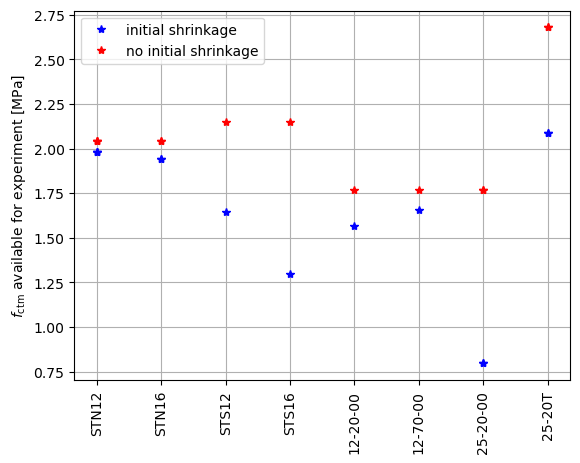

In [21]:
plt.plot(df_ys_full["ELID"],df_ys_full["fctm"].astype("float"),"*b",label="initial shrinkage");
plt.plot(df_ns_full["ELID"],df_ns_full["fctm"],"*r",label="no initial shrinkage");
plt.legend();
plt.xticks(rotation=90);
plt.grid();
plt.ylabel("$f_{\\rm{ctm}}$ available for experiment [MPa]");

### 5.5 - Create lists per crack width formula

#### EN 1992-1-1

In [22]:
list_001a = np.zeros((df_ns["wmax_001a"].shape[0],4));
epsinlist = [];
sigslist = [];
for i in range(df_ns["wmax_001a"].shape[0]):
    list_001a[i,0] = df_ns["wmax_001a"].iloc[i];
    list_001a[i,1] = df_ys["wmax_001a"].iloc[i];
    list_001a[i,2] = df_ns["meas_wmax"].iloc[i];
    list_001a[i,3] = df_ns["sigs"].iloc[i];
    epsinlist.append(df_ns["epsin"].iloc[i]);
    sigslist.append(df_ns["sigs"].iloc[i]);
list_001a = pd.DataFrame(list_001a,columns=["wmax_001a_ns","wmax_001a_ys","meas_wmax","sigs"]);
list_001a["epsin"] = epsinlist;
list_001a.dropna(inplace=True);

In [23]:
list_001a_bend = list_001a[list_001a["epsin"] == str(2)];
list_001a_tens = list_001a[list_001a["epsin"] == str("1a")];

#### NEN-EN 1992-1-1

In [24]:
list_001b = np.zeros((df_ns["wmax_001b"].shape[0],3));
epsinlist = [];
for i in range(df_ns["wmax_001b"].shape[0]):
    list_001b[i,0] = df_ns["wmax_001b"].iloc[i];
    list_001b[i,1] = df_ys["wmax_001b"].iloc[i];
    list_001b[i,2] = df_ns["meas_wmax"].iloc[i];
    epsinlist.append(df_ns["epsin"].iloc[i]);
list_001b = pd.DataFrame(list_001b,columns=["wmax_001b_ns","wmax_001b_ys","meas_wmax"]);
list_001b["epsin"] = epsinlist;
list_001b.dropna(inplace=True);

In [25]:
list_001b_bend = list_001b[list_001b["epsin"] == str(2)];
list_001b_tens = list_001b[list_001b["epsin"] == str("1a")];

#### FprEN 1992-1-1

In [26]:
list_002 = np.zeros((df_ns["wmax_002"].shape[0],3));
epsinlist = [];
for i in range(df_ns["wmax_002"].shape[0]):
    list_002[i,0] = df_ns["wmax_002"].iloc[i];
    list_002[i,1] = df_ys["wmax_002"].iloc[i];
    list_002[i,2] = df_ns["meas_wmax"].iloc[i];
    epsinlist.append(df_ns["epsin"].iloc[i]);
list_002 = pd.DataFrame(list_002,columns=["wmax_002_ns","wmax_002_ys","meas_wmax"]);
list_002["epsin"] = epsinlist;
list_002.dropna(inplace=True);

In [27]:
list_002_bend = list_002[list_002["epsin"] == str(2)];
list_002_tens = list_002[list_002["epsin"] == str("1a")];

#### *fib* MC 2010

In [28]:
list_006 = np.zeros((df_ns["wmax_006"].shape[0],3));
epsinlist = [];
for i in range(df_ns["wmax_006"].shape[0]):
    list_006[i,0] = df_ns["wmax_006"].iloc[i];
    list_006[i,1] = df_ys["wmax_006"].iloc[i];
    list_006[i,2] = df_ns["meas_wmax"].iloc[i];
    epsinlist.append(df_ns["epsin"].iloc[i]);
list_006 = pd.DataFrame(list_006,columns=["wmax_006_ns","wmax_006_ys","meas_wmax"]);
list_006["epsin"] = epsinlist;
list_006.dropna(inplace=True);

In [29]:
list_006_bend = list_006[list_006["epsin"] == str(2)];
list_006_tens = list_006[list_006["epsin"] == str("1a")];

#### *fib* MC 2020

In [30]:
list_007 = np.zeros((df_ns["wmax_007"].shape[0],3));
epsinlist = [];
for i in range(df_ns["wmax_007"].shape[0]):
    list_007[i,0] = df_ns["wmax_007"].iloc[i];
    list_007[i,1] = df_ys["wmax_007"].iloc[i];
    list_007[i,2] = df_ns["meas_wmax"].iloc[i];
    epsinlist.append(df_ns["epsin"].iloc[i]);
list_007 = pd.DataFrame(list_007,columns=["wmax_007_ns","wmax_007_ys","meas_wmax"]);
list_007["epsin"] = epsinlist;
list_007.dropna(inplace=True);

In [31]:
list_007_bend = list_007[list_007["epsin"] == str(2)];
list_007_tens = list_007[list_007["epsin"] == str("1a")];

#### Noakowski

In [32]:
list_012 = np.zeros((df_ns["wmax_012"].shape[0],3));
epsinlist = [];
for i in range(df_ns["wmax_012"].shape[0]):
    list_012[i,0] = df_ns["wmax_012"].iloc[i];
    list_012[i,1] = df_ys["wmax_012"].iloc[i];
    list_012[i,2] = df_ns["meas_wmax"].iloc[i];
    epsinlist.append(df_ns["epsin"].iloc[i]);
list_012 = pd.DataFrame(list_012,columns=["wmax_012_ns","wmax_012_ys","meas_wmax"]);
list_012["epsin"] = epsinlist;
list_012.dropna(inplace=True);

In [33]:
list_012_bend = list_012[list_012["epsin"] == str(2)];
list_012_tens = list_012[list_012["epsin"] == str("1a")];

#### JSCE (Japan Society of Civil Engineers)

In [34]:
list_038 = np.zeros((df_ns["wmax_038"].shape[0],3));
epsinlist = [];
for i in range(df_ns["wmax_038"].shape[0]):
    list_038[i,0] = df_ns["wmax_038"].iloc[i];
    list_038[i,1] = df_ys["wmax_038"].iloc[i];
    list_038[i,2] = df_ns["meas_wmax"].iloc[i];
    epsinlist.append(df_ns["epsin"].iloc[i]);
list_038 = pd.DataFrame(list_038,columns=["wmax_038_ns","wmax_038_ys","meas_wmax"]);
list_038["epsin"] = epsinlist;
list_038.dropna(inplace=True);

In [35]:
list_038_bend = list_038[list_038["epsin"] == str(2)];
list_038_tens = list_038[list_038["epsin"] == str("1a")];

#### Oh and Kang

In [36]:
list_047 = np.zeros((df_ns["wmax_047"].shape[0],3));
epsinlist = [];
for i in range(df_ns["wmax_047"].shape[0]):
    list_047[i,0] = df_ns["wmax_047"].iloc[i];
    list_047[i,1] = df_ys["wmax_047"].iloc[i];
    list_047[i,2] = df_ns["meas_wmax"].iloc[i];
    epsinlist.append(df_ns["epsin"].iloc[i]);
list_047 = pd.DataFrame(list_047,columns=["wmax_047_ns","wmax_047_ys","meas_wmax"]);
list_047["epsin"] = epsinlist;
list_047.dropna(inplace=True);

In [37]:
list_047_bend = list_047[list_047["epsin"] == str(2)];
list_047_tens = list_047[list_047["epsin"] == str("1a")];

#### Gergely and Lutz

In [38]:
list_053 = np.zeros((df_ns["wmax_053"].shape[0],3));
epsinlist = [];
for i in range(df_ns["wmax_053"].shape[0]):
    list_053[i,0] = df_ns["wmax_053"].iloc[i];
    list_053[i,1] = df_ns["wmax_053"].iloc[i]; # Take care: instead of df_ys --> df_ns; since initial shrinkage shouldn't have effects!
    list_053[i,2] = df_ns["meas_wmax"].iloc[i];
    epsinlist.append(df_ns["epsin"].iloc[i]);
list_053 = pd.DataFrame(list_053,columns=["wmax_053_ns","wmax_053_ys","meas_wmax"]);
list_053["epsin"] = epsinlist
list_053.dropna(inplace=True);

In [39]:
list_053_bend = list_053[list_053["epsin"] == str(2)];
list_053_tens = list_053[list_053["epsin"] == str("1a")];

## 6 - Analysis and plots

Three groups are created:\
-Group 1: no initial shrinkage \
-Group 2: $(1-k_{\mathrm{t}})\epsilon_{\mathrm{cs,free}}$; tension stiffening is considered in the respective formula \
-Group 3: $\epsilon_{\mathrm{cs,free}}$; tension stiffening is not considered

The considered CWFs are related to the three different groups:\
-Group 1: no initial shrinkage:\
$\quad$ -Gergely and Lutz

-Group 2: $(1-k_t)\epsilon_{\mathrm{cs,free}}$:\
$\quad$ -EN 1992-1-1\
$\quad$ -NEN-EN 1992-1-1\
$\quad$ -FprEN 1992-1-1\
$\quad$ -*fib* MC 2010\
$\quad$ -*fib* MC 2020\
$\quad$ -Noakowski

-Group 3: $\epsilon_{\mathrm{cs,free}}$:\
$\quad$ -JSCE\
$\quad$ -Oh and Kang

### Group 1: no initial shrinkage

#### Gergely and Lutz

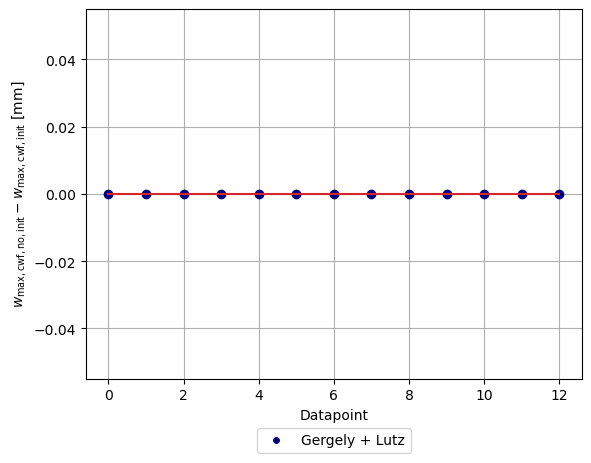

In [40]:
legend_elements = [Line2D([], [], marker = "o", color="white", markerfacecolor=col_053, lw=1, label='Gergely + Lutz'),
                  ];

plt.stem(list_053["wmax_053_ns"]-list_053["wmax_053_ys"],markerfmt=col_053);

plt.legend(handles=legend_elements, loc="lower center",ncol=6,bbox_to_anchor=(0.5,-0.22));

plt.ylabel("$w_{\\rm{max,cwf,no,init}} - w_{\\rm{max,cwf,init}} $ [mm]");
plt.xlabel("Datapoint");
plt.grid();

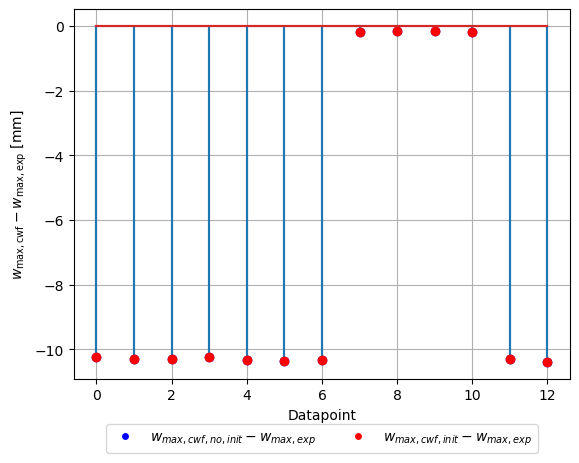

In [41]:
legend_elements = [
    Line2D([], [], marker = "o", color="white", markerfacecolor="b", lw=1, label='$w_{max,cwf,no,init} - w_{max,exp} $'),
    Line2D([], [], marker = "o", color="white", markerfacecolor="r", lw=1, label='$w_{max,cwf,init} - w_{max,exp} $'),
                  ];

plt.stem(list_053["wmax_053_ns"]-list_053["meas_wmax"],markerfmt="b");
plt.stem(list_053["wmax_053_ys"]-list_053["meas_wmax"],markerfmt="r");

plt.legend(handles=legend_elements, loc="lower center",ncol=6,bbox_to_anchor=(0.5,-0.22));

plt.ylabel("$w_{\\rm{max,cwf}} - w_{\\rm{max,exp}} $ [mm]");
plt.xlabel("Datapoint");
plt.grid();

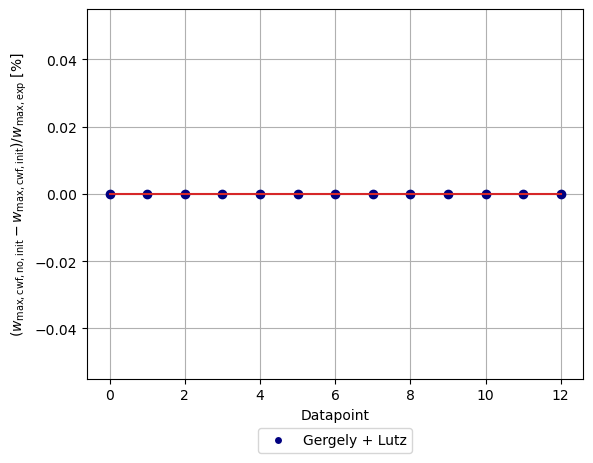

In [42]:
legend_elements = [Line2D([], [], marker = "o", color="white", markerfacecolor=col_053, lw=1, label='Gergely + Lutz'),
                  ];

plt.stem(100*(list_053["wmax_053_ns"]-list_053["wmax_053_ys"])/list_053["meas_wmax"],markerfmt=col_053);

plt.legend(handles=legend_elements, loc="lower center",ncol=6,bbox_to_anchor=(0.5,-0.22));

plt.ylabel("$(w_{\\rm{max,cwf,no,init}} - w_{\\rm{max,cwf,init}})/w_{\\rm{max,exp}} $ [%]");
plt.xlabel("Datapoint");
plt.grid();

In [43]:
print("CWF 053 - Gergely + Lutz");
print("\n");
print("Ratio w_cwf/w_meas - no init shrink: mean=",np.round(np.mean(list_053["wmax_053_ns"]/list_053["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink: mean=",np.round(np.mean(list_053["wmax_053_ys"]/list_053["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + bending: mean=",np.round(np.mean(list_053_bend["wmax_053_ns"]/list_053_bend["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + bending: mean=",np.round(np.mean(list_053_bend["wmax_053_ys"]/list_053_bend["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + tension: mean=",np.round(np.mean(list_053_tens["wmax_053_ns"]/list_053_tens["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + tension: mean=",np.round(np.mean(list_053_tens["wmax_053_ys"]/list_053_tens["meas_wmax"]),3));

CWF 053 - Gergely + Lutz


Ratio w_cwf/w_meas - no init shrink: mean= -22.53
Ratio w_cwf/w_meas - init shrink: mean= -22.53


Ratio w_cwf/w_meas - no init shrink + bending: mean= 0.548
Ratio w_cwf/w_meas - init shrink + bending: mean= 0.548


Ratio w_cwf/w_meas - no init shrink + tension: mean= -32.786
Ratio w_cwf/w_meas - init shrink + tension: mean= -32.786


### Group 2: $(1-k_t)\epsilon_{\mathrm{cs,free}}$

#### Summary

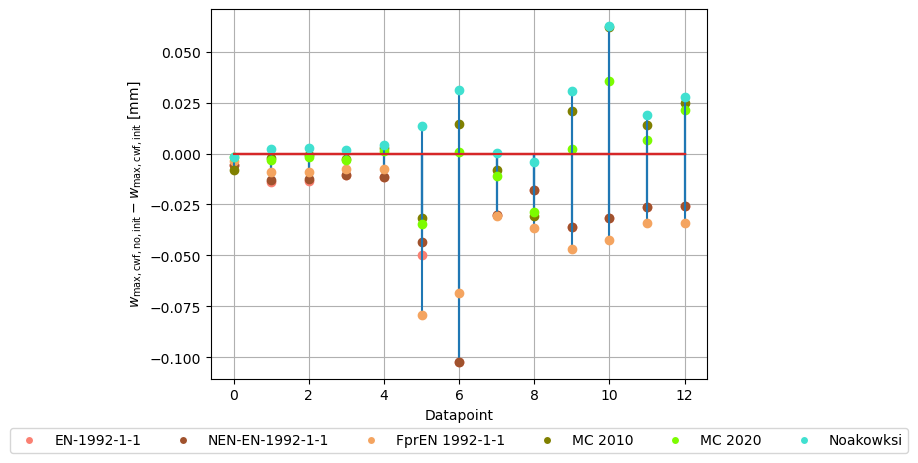

In [44]:
legend_elements = [Line2D([], [], marker = "o", color="white", markerfacecolor=col_001a, lw=1, label='EN-1992-1-1'),
                   Line2D([], [], marker = "o", color="white", markerfacecolor=col_001b, lw=1, label='NEN-EN-1992-1-1'),
                   Line2D([], [], marker = "o", color="white", markerfacecolor=col_002, lw=1, label='FprEN 1992-1-1'),
                   Line2D([], [], marker = "o", color="white", markerfacecolor=col_006, lw=1, label='MC 2010'),
                   Line2D([], [], marker = "o", color="white", markerfacecolor=col_007, lw=1, label='MC 2020'),
                   Line2D([], [], marker = "o", color="white", markerfacecolor=col_012, lw=1, label='Noakowksi'),
                  ];

plt.stem(list_001a["wmax_001a_ns"]-list_001a["wmax_001a_ys"],markerfmt=col_001a);
plt.stem(list_001b["wmax_001b_ns"]-list_001b["wmax_001b_ys"],markerfmt=col_001b);
plt.stem(list_002["wmax_002_ns"]-list_002["wmax_002_ys"],markerfmt=col_002);
plt.stem(list_006["wmax_006_ns"]-list_006["wmax_006_ys"],markerfmt=col_006);
plt.stem(list_007["wmax_007_ns"]-list_007["wmax_007_ys"],markerfmt=col_007);
plt.stem(list_012["wmax_012_ns"]-list_012["wmax_012_ys"],markerfmt=col_012);

plt.legend(handles=legend_elements, loc="lower center",ncol=6,bbox_to_anchor=(0.5,-0.22));

plt.ylabel("$w_{\\rm{max,cwf,no,init}} - w_{\\rm{max,cwf,init}} $ [mm]");
plt.xlabel("Datapoint");
plt.grid();

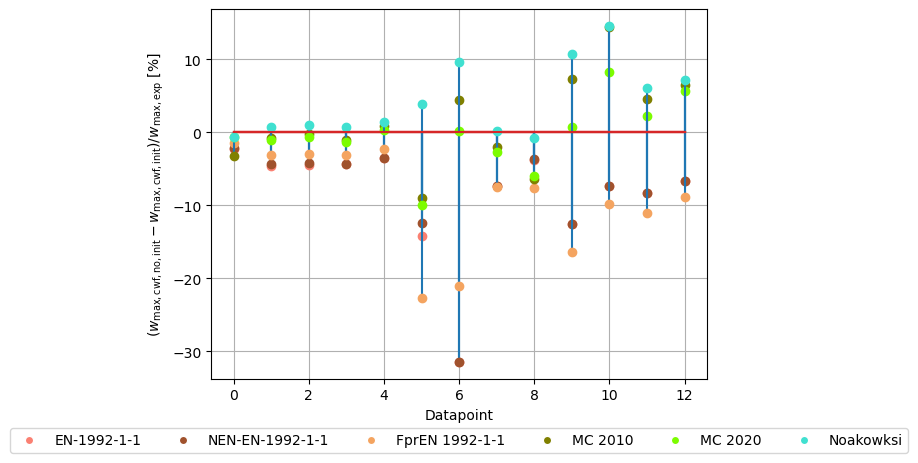

In [45]:
legend_elements = [Line2D([], [], marker = "o", color="white", markerfacecolor=col_001a, lw=1, label='EN-1992-1-1'),
                   Line2D([], [], marker = "o", color="white", markerfacecolor=col_001b, lw=1, label='NEN-EN-1992-1-1'),
                   Line2D([], [], marker = "o", color="white", markerfacecolor=col_002, lw=1, label='FprEN 1992-1-1'),
                   Line2D([], [], marker = "o", color="white", markerfacecolor=col_006, lw=1, label='MC 2010'),
                   Line2D([], [], marker = "o", color="white", markerfacecolor=col_007, lw=1, label='MC 2020'),
                   Line2D([], [], marker = "o", color="white", markerfacecolor=col_012, lw=1, label='Noakowksi')
                  ];

plt.stem(100*(list_001a["wmax_001a_ns"]-list_001a["wmax_001a_ys"])/list_001a["meas_wmax"],markerfmt=col_001a);
plt.stem(100*(list_001b["wmax_001b_ns"]-list_001b["wmax_001b_ys"])/list_001b["meas_wmax"],markerfmt=col_001b);
plt.stem(100*(list_002["wmax_002_ns"]-list_002["wmax_002_ys"])/list_002["meas_wmax"],markerfmt=col_002);
plt.stem(100*(list_006["wmax_006_ns"]-list_006["wmax_006_ys"])/list_006["meas_wmax"],markerfmt=col_006);
plt.stem(100*(list_007["wmax_007_ns"]-list_007["wmax_007_ys"])/list_007["meas_wmax"],markerfmt=col_007);
plt.stem(100*(list_012["wmax_012_ns"]-list_012["wmax_012_ys"])/list_012["meas_wmax"],markerfmt=col_012);

plt.legend(handles=legend_elements, loc="lower center",ncol=6,bbox_to_anchor=(0.5,-0.22));

plt.ylabel("$(w_{\\rm{max,cwf,no,init}} - w_{\\rm{max,cwf,init}})/w_{\\rm{max,exp}} $ [%]");
plt.xlabel("Datapoint");
plt.grid();

#### EN 1992-1-1

In [46]:
print("CWF 001 - EN 1992-1-1");
print("\n");
print("Ratio w_cwf/w_meas - no init shrink: mean=",np.round(np.mean(list_001a["wmax_001a_ns"]/list_001a["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink: mean=",np.round(np.mean(list_001a["wmax_001a_ys"]/list_001a["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + bending: mean=",np.round(np.mean(list_001a_bend["wmax_001a_ns"]/list_001a_bend["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + bending: mean=",np.round(np.mean(list_001a_bend["wmax_001a_ys"]/list_001a_bend["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + tension: mean=",np.round(np.mean(list_001a_tens["wmax_001a_ns"]/list_001a_tens["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + tension: mean=",np.round(np.mean(list_001a_tens["wmax_001a_ys"]/list_001a_tens["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf_ys/w_cwf_ns + bending: mean =",np.round(np.mean(list_001a_bend["wmax_001a_ys"]/list_001a_bend["wmax_001a_ns"]),3));

CWF 001 - EN 1992-1-1


Ratio w_cwf/w_meas - no init shrink: mean= 0.979
Ratio w_cwf/w_meas - init shrink: mean= 1.065


Ratio w_cwf/w_meas - no init shrink + bending: mean= 0.503
Ratio w_cwf/w_meas - init shrink + bending: mean= 0.581


Ratio w_cwf/w_meas - no init shrink + tension: mean= 1.191
Ratio w_cwf/w_meas - init shrink + tension: mean= 1.28


Ratio w_cwf_ys/w_cwf_ns + bending: mean = 1.167


#### NEN-EN 1992-1-1

In [47]:
print("CWF 001b - NEN-EN 1992-1-1");
print("\n");
print("Ratio w_cwf/w_meas - no init shrink: mean=",np.round(np.mean(list_001b["wmax_001b_ns"]/list_001b["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink: mean=",np.round(np.mean(list_001b["wmax_001b_ys"]/list_001b["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + bending: mean=",np.round(np.mean(list_001b_bend["wmax_001b_ns"]/list_001b_bend["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + bending: mean=",np.round(np.mean(list_001b_bend["wmax_001b_ys"]/list_001b_bend["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + tension: mean=",np.round(np.mean(list_001b_tens["wmax_001b_ns"]/list_001b_tens["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + tension: mean=",np.round(np.mean(list_001b_tens["wmax_001b_ys"]/list_001b_tens["meas_wmax"]),3));

CWF 001b - NEN-EN 1992-1-1


Ratio w_cwf/w_meas - no init shrink: mean= 0.945
Ratio w_cwf/w_meas - init shrink: mean= 1.029


Ratio w_cwf/w_meas - no init shrink + bending: mean= 0.502
Ratio w_cwf/w_meas - init shrink + bending: mean= 0.58


Ratio w_cwf/w_meas - no init shrink + tension: mean= 1.142
Ratio w_cwf/w_meas - init shrink + tension: mean= 1.228


#### EN 1992-1-1 (2023)

In [48]:
print("CWF 002 - FprEN 1992-1-1");
print("\n");
print("Ratio w_cwf/w_meas - no init shrink: mean=",np.round(np.mean(list_002["wmax_002_ns"]/list_002["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink: mean=",np.round(np.mean(list_002["wmax_002_ys"]/list_002["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + bending: mean=",np.round(np.mean(list_002_bend["wmax_002_ns"]/list_002_bend["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + bending: mean=",np.round(np.mean(list_002_bend["wmax_002_ys"]/list_002_bend["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + tension: mean=",np.round(np.mean(list_002_tens["wmax_002_ns"]/list_002_tens["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + tension: mean=",np.round(np.mean(list_002_tens["wmax_002_ys"]/list_002_tens["meas_wmax"]),3));

CWF 002 - FprEN 1992-1-1


Ratio w_cwf/w_meas - no init shrink: mean= 0.698
Ratio w_cwf/w_meas - init shrink: mean= 0.789


Ratio w_cwf/w_meas - no init shrink + bending: mean= 0.494
Ratio w_cwf/w_meas - init shrink + bending: mean= 0.597


Ratio w_cwf/w_meas - no init shrink + tension: mean= 0.788
Ratio w_cwf/w_meas - init shrink + tension: mean= 0.873


#### *fib* MC 2010

In [49]:
print("CWF 006 - MC 2010");
print("\n");
print("Ratio w_cwf/w_meas - no init shrink: mean=",np.round(np.mean(list_006["wmax_006_ns"]/list_006["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink: mean=",np.round(np.mean(list_006["wmax_006_ys"]/list_006["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + bending: mean=",np.round(np.mean(list_006_bend["wmax_006_ns"]/list_006_bend["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + bending: mean=",np.round(np.mean(list_006_bend["wmax_006_ys"]/list_006_bend["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + tension: mean=",np.round(np.mean(list_006_tens["wmax_006_ns"]/list_006_tens["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + tension: mean=",np.round(np.mean(list_006_tens["wmax_006_ys"]/list_006_tens["meas_wmax"]),3));

CWF 006 - MC 2010


Ratio w_cwf/w_meas - no init shrink: mean= 0.757
Ratio w_cwf/w_meas - init shrink: mean= 0.745


Ratio w_cwf/w_meas - no init shrink + bending: mean= 0.598
Ratio w_cwf/w_meas - init shrink + bending: mean= 0.565


Ratio w_cwf/w_meas - no init shrink + tension: mean= 0.827
Ratio w_cwf/w_meas - init shrink + tension: mean= 0.825


#### *fib* MC 2020

In [50]:
print("CWF 007 - MC 2020");
print("\n");
print("Ratio w_cwf/w_meas - no init shrink: mean=",np.round(np.mean(list_007["wmax_007_ns"]/list_007["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink: mean=",np.round(np.mean(list_007["wmax_007_ys"]/list_007["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + bending: mean=",np.round(np.mean(list_007_bend["wmax_007_ns"]/list_007_bend["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + bending: mean=",np.round(np.mean(list_007_bend["wmax_007_ys"]/list_007_bend["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + tension: mean=",np.round(np.mean(list_007_tens["wmax_007_ns"]/list_007_tens["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + tension: mean=",np.round(np.mean(list_007_tens["wmax_007_ys"]/list_007_tens["meas_wmax"]),3));

CWF 007 - MC 2020


Ratio w_cwf/w_meas - no init shrink: mean= 0.704
Ratio w_cwf/w_meas - init shrink: mean= 0.708


Ratio w_cwf/w_meas - no init shrink + bending: mean= 0.494
Ratio w_cwf/w_meas - init shrink + bending: mean= 0.493


Ratio w_cwf/w_meas - no init shrink + tension: mean= 0.798
Ratio w_cwf/w_meas - init shrink + tension: mean= 0.804


#### Noakowski

In [51]:
print("CWF 012 - Noakowski");
print("\n");
print("Ratio w_cwf/w_meas - no init shrink: mean=",np.round(np.mean(list_012["wmax_012_ns"]/list_012["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink: mean=",np.round(np.mean(list_012["wmax_012_ys"]/list_012["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + bending: mean=",np.round(np.mean(list_012_bend["wmax_012_ns"]/list_012_bend["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + bending: mean=",np.round(np.mean(list_012_bend["wmax_012_ys"]/list_012_bend["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + tension: mean=",np.round(np.mean(list_012_tens["wmax_012_ns"]/list_012_tens["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + tension: mean=",np.round(np.mean(list_012_tens["wmax_012_ys"]/list_012_tens["meas_wmax"]),3));

CWF 012 - Noakowski


Ratio w_cwf/w_meas - no init shrink: mean= 0.501
Ratio w_cwf/w_meas - init shrink: mean= 0.459


Ratio w_cwf/w_meas - no init shrink + bending: mean= 0.385
Ratio w_cwf/w_meas - init shrink + bending: mean= 0.324


Ratio w_cwf/w_meas - no init shrink + tension: mean= 0.552
Ratio w_cwf/w_meas - init shrink + tension: mean= 0.519


### Group 3: $\epsilon_{\mathrm{cs,free}}$

#### Summary

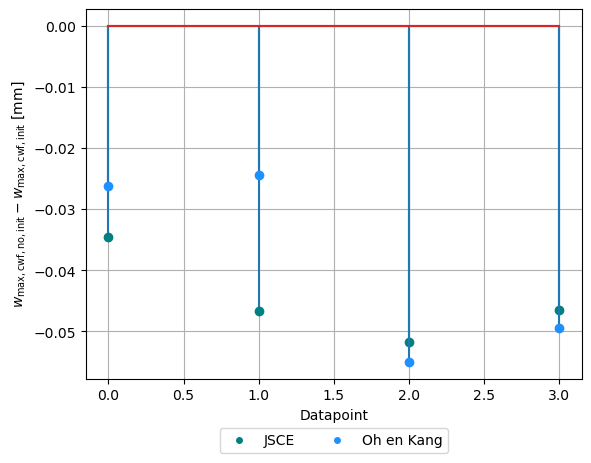

In [52]:
legend_elements = [Line2D([], [], marker = "o", color="white", markerfacecolor=col_038, lw=1, label='JSCE'),
                   Line2D([], [], marker = "o", color="white", markerfacecolor=col_047, lw=1, label='Oh en Kang'),
                  ];

plt.stem(list_038["wmax_038_ns"]-list_038["wmax_038_ys"],markerfmt=col_038);
plt.stem(list_047["wmax_047_ns"]-list_047["wmax_047_ys"],markerfmt=col_047);

plt.legend(handles=legend_elements, loc="lower center",ncol=6,bbox_to_anchor=(0.5,-0.22));

plt.ylabel("$w_{\\rm{max,cwf,no,init}} - w_{\\rm{max,cwf,init}} $ [mm]");
plt.xlabel("Datapoint");
plt.grid();

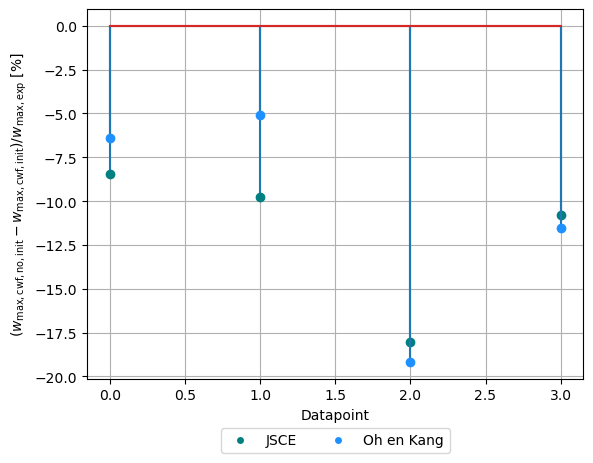

In [53]:
legend_elements = [Line2D([], [], marker = "o", color="white", markerfacecolor=col_038, lw=1, label='JSCE'),
                   Line2D([], [], marker = "o", color="white", markerfacecolor=col_047, lw=1, label='Oh en Kang'),
                  ];

plt.stem(100*(list_038["wmax_038_ns"]-list_038["wmax_038_ys"])/list_038["meas_wmax"],markerfmt=col_038);
plt.stem(100*(list_047["wmax_047_ns"]-list_047["wmax_047_ys"])/list_047["meas_wmax"],markerfmt=col_047);

plt.legend(handles=legend_elements, loc="lower center",ncol=6,bbox_to_anchor=(0.5,-0.22));

plt.ylabel("$(w_{\\rm{max,cwf,no,init}} - w_{\\rm{max,cwf,init}})/w_{\\rm{max,exp}} $ [%]");
plt.xlabel("Datapoint");
plt.grid();

#### Japan Society of Civil Engineers

In [54]:
print("CWF 038 - JSCE");
print("\n");
print("Ratio w_cwf/w_meas - no init shrink: mean=",np.round(np.mean(list_038["wmax_038_ns"]/list_038["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink: mean=",np.round(np.mean(list_038["wmax_038_ys"]/list_038["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + bending: mean=",np.round(np.mean(list_038_bend["wmax_038_ns"]/list_038_bend["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + bending: mean=",np.round(np.mean(list_038_bend["wmax_038_ys"]/list_038_bend["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + tension: mean=",np.round(np.mean(list_038_tens["wmax_038_ns"]/list_038_tens["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + tension: mean=",np.round(np.mean(list_038_tens["wmax_038_ys"]/list_038_tens["meas_wmax"]),3));

CWF 038 - JSCE


Ratio w_cwf/w_meas - no init shrink: mean= 0.76
Ratio w_cwf/w_meas - init shrink: mean= 0.878


Ratio w_cwf/w_meas - no init shrink + bending: mean= 0.76
Ratio w_cwf/w_meas - init shrink + bending: mean= 0.878


Ratio w_cwf/w_meas - no init shrink + tension: mean= nan
Ratio w_cwf/w_meas - init shrink + tension: mean= nan


#### Oh and Kang

In [55]:
print("CWF 047 - Oh + Kang");
print("\n");
print("Ratio w_cwf/w_meas - no init shrink: mean=",np.round(np.mean(list_047["wmax_047_ns"]/list_038["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink: mean=",np.round(np.mean(list_047["wmax_047_ys"]/list_038["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + bending: mean=",np.round(np.mean(list_047_bend["wmax_047_ns"]/list_047_bend["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + bending: mean=",np.round(np.mean(list_047_bend["wmax_047_ys"]/list_047_bend["meas_wmax"]),3));
print("\n");
print("Ratio w_cwf/w_meas - no init shrink + tension: mean=",np.round(np.mean(list_047_tens["wmax_047_ns"]/list_047_tens["meas_wmax"]),3));
print("Ratio w_cwf/w_meas - init shrink + tension: mean=",np.round(np.mean(list_047_tens["wmax_047_ys"]/list_047_tens["meas_wmax"]),3));

CWF 047 - Oh + Kang


Ratio w_cwf/w_meas - no init shrink: mean= 0.496
Ratio w_cwf/w_meas - init shrink: mean= 0.602


Ratio w_cwf/w_meas - no init shrink + bending: mean= 0.496
Ratio w_cwf/w_meas - init shrink + bending: mean= 0.602


Ratio w_cwf/w_meas - no init shrink + tension: mean= nan
Ratio w_cwf/w_meas - init shrink + tension: mean= nan
